In [1]:
import numpy as np
import pandas as pd
import gc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
import xgboost as xgb
from pytorch_tabnet.tab_model import TabNetClassifier
import pickle
import shap
import matplotlib.pyplot as plt
import xgboost

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, log_loss
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

from functools import partial

from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

from bo_parameters import *

In [5]:
lgbm_tuned = {
    "learning_rate" : 0.14244374976727375, 
    "max_depth" : 5, 
    "n_estimators" : 198
}
# lgbm_tuned += LIGHTGBM_PARAMS

xgb_tuned = {
    "learning_rate" : 0.437344281810245, 
    "max_depth" : 5, 
    "n_estimators" : 920
}
# xgb_tuned += XGBOOST_PARAMS

tabnet_tuned = {
    "gamma" : 1.1227966185155351, 
    "lambda_sparse" : 0.05232096763520789, 
    "n_steps" : 4,
    "n_a" : 24,
    "momentum" : 0.7,
}
tabnet_tuned["n_d"] = tabnet_tuned["n_a"]

tabnet_paper = {
    "gamma" : 1.5, 
    "lambda_sparse" : 0.004, 
    "n_steps" : 5,
    "n_a" : 16,
    "momentum" : 0.7,
}
tabnet_paper["n_d"] = tabnet_paper["n_a"]

In [6]:
data = pd.read_csv("data/synthetic/syn5/data.csv")

In [7]:
train = pd.read_csv("data/synthetic/syn5/train.csv")
valid = pd.read_csv("data/synthetic/syn5/val.csv")
test = pd.read_csv("data/synthetic/syn5/test.csv")

In [8]:
train.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,TARGET
0,0.325858,0.697184,0.812222,2.140518,0.325858,0.697184,0.812222,2.140518,1.223960,0.188322,-4.019868,0
1,-0.170500,-0.241799,-0.679737,0.770884,-1.049472,1.308436,-0.390377,-0.395647,-1.141868,1.099354,3.645112,0
2,-0.653021,-0.696606,0.518960,-0.436847,-0.653021,-0.696606,0.518960,-0.436847,0.302409,-0.050042,-2.493129,0
3,0.850964,-1.965242,-0.200949,1.125162,0.507335,-1.004379,-0.099335,-1.313870,-0.686837,1.209220,3.551766,1
4,-0.407988,-1.312217,0.364332,-0.865937,0.982733,0.056740,-2.006299,-0.185867,-0.120750,1.283596,3.424538,0


In [9]:
train = pd.concat([train, valid])

In [10]:
train_X = train.drop(["TARGET"], axis=1)
train_y = train["TARGET"]

test_X = test.drop(["TARGET"], axis=1)
test_y = test["TARGET"]

In [11]:
model_lgbm = LGBMClassifier(**{**lgbm_tuned, **LIGHTGBM_PARAMS})
model_lgbm.fit(train_X, train_y, verbose=1)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMClassifier(learning_rate=0.14244374976727375, max_depth=5, metric='auc',
               n_estimators=198, objective='binary', random_state=42)

In [12]:
model_xgb = XGBClassifier(**{**xgb_tuned, **XGBOOST_PARAMS})
model_xgb.fit(train_X, train_y, verbose=1)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[23:47:55] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:47:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.437344281810245, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=920, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [13]:
TABNET_PARAMS["verbose"] = 1

In [14]:
model_tabnet = TabNetClassifier(**{**tabnet_tuned, **TABNET_PARAMS})
model_tabnet.fit(train_X.values, train_y.values, max_epochs=60)

Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.613   |  0:00:02s
epoch 1  | loss: 0.35932 |  0:00:05s
epoch 2  | loss: 0.28923 |  0:00:08s
epoch 3  | loss: 0.26954 |  0:00:11s
epoch 4  | loss: 0.25874 |  0:00:14s
epoch 5  | loss: 0.24691 |  0:00:16s
epoch 6  | loss: 0.23038 |  0:00:19s
epoch 7  | loss: 0.21716 |  0:00:22s
epoch 8  | loss: 0.19493 |  0:00:24s
epoch 9  | loss: 0.19753 |  0:00:27s
epoch 10 | loss: 0.18879 |  0:00:30s
epoch 11 | loss: 0.18524 |  0:00:33s
epoch 12 | loss: 0.1665  |  0:00:36s
epoch 13 | loss: 0.16408 |  0:00:38s
epoch 14 | loss: 0.16328 |  0:00:41s
epoch 15 | loss: 0.15696 |  0:00:44s
epoch 16 | loss: 0.14464 |  0:00:46s
epoch 17 | loss: 0.14058 |  0:00:49s
epoch 18 | loss: 0.13811 |  0:00:52s
epoch 19 | loss: 0.13061 |  0:00:55s
epoch 20 | loss: 0.13601 |  0:00:57s
epoch 21 | loss: 0.13296 |  0:01:00s
epoch 22 | loss: 0.12688 |  0:01:03s
epoch 23 | loss: 0.13014 |  0:01:06s
epoch 24 | loss: 0.11

In [15]:
model_tabnet_paper = TabNetClassifier(**{**tabnet_paper, **TABNET_PARAMS})
model_tabnet_paper.fit(train_X.values, train_y.values, max_epochs=60, batch_size=3000, virtual_batch_size=100)

Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.95103 |  0:00:01s
epoch 1  | loss: 0.60275 |  0:00:02s
epoch 2  | loss: 0.51365 |  0:00:03s
epoch 3  | loss: 0.46871 |  0:00:04s
epoch 4  | loss: 0.41295 |  0:00:05s
epoch 5  | loss: 0.38342 |  0:00:07s
epoch 6  | loss: 0.35593 |  0:00:08s
epoch 7  | loss: 0.35394 |  0:00:09s
epoch 8  | loss: 0.35338 |  0:00:10s
epoch 9  | loss: 0.33224 |  0:00:11s
epoch 10 | loss: 0.31095 |  0:00:12s
epoch 11 | loss: 0.29633 |  0:00:14s
epoch 12 | loss: 0.28182 |  0:00:15s
epoch 13 | loss: 0.28915 |  0:00:16s
epoch 14 | loss: 0.27127 |  0:00:17s
epoch 15 | loss: 0.27677 |  0:00:18s
epoch 16 | loss: 0.27018 |  0:00:19s
epoch 17 | loss: 0.2659  |  0:00:20s
epoch 18 | loss: 0.26884 |  0:00:22s
epoch 19 | loss: 0.25313 |  0:00:23s
epoch 20 | loss: 0.25226 |  0:00:24s
epoch 21 | loss: 0.26214 |  0:00:25s
epoch 22 | loss: 0.24876 |  0:00:26s
epoch 23 | loss: 0.24192 |  0:00:27s
epoch 24 | loss: 0.24

In [11]:
with open('model_tabnet.pickle', 'wb') as f:
    pickle.dump(model_tabnet, f)
with open('model_tabnet_paper.pickle', 'wb') as f:
    pickle.dump(model_tabnet_paper, f)

In [10]:
with open('model_tabnet.pickle', 'rb') as f:
    model_tabnet = pickle.load(f)
with open('model_tabnet_paper.pickle', 'rb') as f:
    model_tabnet_paper = pickle.load(f)

In [16]:
print("LightGBM auc: ", round(roc_auc_score(test_y, model_lgbm.predict_proba(test_X)[:, 1]), 6))
print("XGBoost auc: ", round(roc_auc_score(test_y, model_xgb.predict_proba(test_X)[:, 1]), 6))
print("TabNet auc: ", round(roc_auc_score(test_y, model_tabnet.predict_proba(test_X.values)[:, 1]), 6))
print("TabNet Paper auc: ", round(roc_auc_score(test_y, model_tabnet_paper.predict_proba(test_X.values)[:, 1]), 6))

LightGBM auc:  0.994257
XGBoost auc:  0.99333
TabNet auc:  0.992631
TabNet Paper auc:  0.985884


In [17]:
print("LightGBM acc: ", round(accuracy_score(test_y, model_lgbm.predict(test_X)), 6))
print("XGBoost acc: ", round(accuracy_score(test_y, model_xgb.predict(test_X)), 6))
print("TabNet acc: ", round(accuracy_score(test_y, model_tabnet.predict(test_X.values)), 6))
print("TabNet Paper acc: ", round(accuracy_score(test_y, model_tabnet_paper.predict(test_X.values)), 6))

LightGBM acc:  0.972019
XGBoost acc:  0.972685
TabNet acc:  0.968688
TabNet Paper acc:  0.944704


In [18]:
print("LightGBM log_loss: ", round(log_loss(test_y, model_lgbm.predict_proba(test_X)), 6))
print("XGBoost log_loss: ", round(log_loss(test_y, model_xgb.predict_proba(test_X)), 6))
print("TabNet log_loss: ", round(log_loss(test_y, model_tabnet.predict_proba(test_X.values)), 6))
print("TabNet Paper log_loss: ", round(log_loss(test_y, model_tabnet_paper.predict_proba(test_X.values)), 6))

LightGBM log_loss:  0.091783
XGBoost log_loss:  0.120335
TabNet log_loss:  0.089274
TabNet Paper log_loss:  0.144407


In [19]:
importance_lgbm = list(enumerate(model_lgbm.feature_importances_))
importance_xgb = model_xgb.get_booster().get_score(importance_type='weight').items()
importance_tabnet = list(enumerate(model_tabnet.feature_importances_))
importance_tabnet_paper = list(enumerate(model_tabnet_paper.feature_importances_))

In [20]:
importance_lgbm = sorted(importance_lgbm, key=lambda x: x[1], reverse=True)
importance_xgb = sorted(importance_xgb, key=lambda x: x[1], reverse=True)
importance_tabnet = sorted(importance_tabnet, key=lambda x: x[1], reverse=True)
importance_tabnet_paper = sorted(importance_tabnet_paper, key=lambda x: x[1], reverse=True)

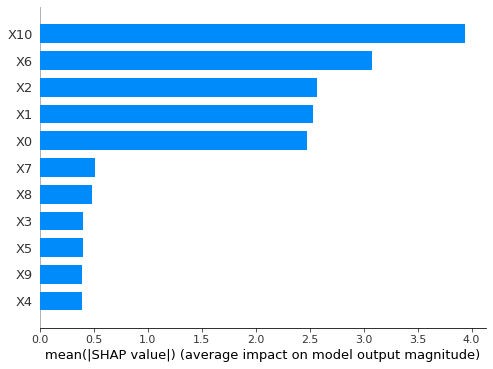

In [21]:
shap_values = shap.TreeExplainer(model_xgb).shap_values(train_X)
shap.summary_plot(shap_values, train_X, plot_type="bar")

In [22]:
df_compare = pd.DataFrame([train.columns[x[0]] for x in importance_lgbm], columns=["LightGBM"])
df_compare["XGBoost"] = [x[0] for x in importance_xgb]
df_compare["SHAP_XGBoost"] = train_X.columns[np.argsort(np.abs(shap_values).mean(0))][::-1]
df_compare["TabNet"] = [train.columns[x[0]] for x in importance_tabnet]
df_compare["TabNet_Paper"] = [train.columns[x[0]] for x in importance_tabnet_paper]

In [23]:
df_compare

,LightGBM,XGBoost,SHAP_XGBoost,TabNet,TabNet_Paper
0,X1,X10,X10,X10,X10
1,X0,X1,X6,X1,X6
2,X10,X0,X2,X6,X1
3,X2,X9,X1,X0,X0
4,X6,X8,X0,X2,X2
5,X8,X2,X7,X5,X5
6,X9,X3,X8,X7,X9
7,X5,X5,X3,X3,X7
8,X4,X7,X5,X4,X3
9,X7,X6,X9,X9,X4


In [24]:
top_3 = []

for i in range(len(df_compare.columns)):
    for j in range(len(df_compare.columns)):
        col1 = df_compare.columns[i]
        col2 = df_compare.columns[j]
        d = []
        d.append(col1)
        d.append(col2)
        d.append(len(set(df_compare.loc[:2, col1]) & set(df_compare.loc[:2, col2])))
        top_3.append(d)
top_3_data = pd.DataFrame(top_3, columns=["Model1", "Model2", "Sim"])
    

In [25]:
pd.pivot_table(top_3_data, values='Sim', index=['Model1'], columns=['Model2'])

Model2,LightGBM,SHAP_XGBoost,TabNet,TabNet_Paper,XGBoost
Model1,,,,,
LightGBM,3,1,2,2,3
SHAP_XGBoost,1,3,2,2,1
TabNet,2,2,3,3,2
TabNet_Paper,2,2,3,3,2
XGBoost,3,1,2,2,3


TODO: 3 признака из каждой и обучить бустинги

In [26]:
top_5 = []

for i in range(len(df_compare.columns)):
    for j in range(len(df_compare.columns)):
        col1 = df_compare.columns[i]
        col2 = df_compare.columns[j]
        d = []
        d.append(col1)
        d.append(col2)
        d.append(len(set(df_compare.loc[:4, col1]) & set(df_compare.loc[:4, col2])))
        top_5.append(d)
top_5_data = pd.DataFrame(top_5, columns=["Model1", "Model2", "Sim"])
    

In [27]:
pd.pivot_table(top_5_data, values='Sim', index=['Model1'], columns=['Model2'])

Model2,LightGBM,SHAP_XGBoost,TabNet,TabNet_Paper,XGBoost
Model1,,,,,
LightGBM,5,5,5,5,3
SHAP_XGBoost,5,5,5,5,3
TabNet,5,5,5,5,3
TabNet_Paper,5,5,5,5,3
XGBoost,3,3,3,3,5


In [28]:
top_10 = []

for i in range(len(df_compare.columns)):
    for j in range(len(df_compare.columns)):
        col1 = df_compare.columns[i]
        col2 = df_compare.columns[j]
        d = []
        d.append(col1)
        d.append(col2)
        d.append(len(set(df_compare.loc[:9, col1]) & set(df_compare.loc[:9, col2])))
        top_10.append(d)
top_10_data = pd.DataFrame(top_10, columns=["Model1", "Model2", "Sim"])
    

In [29]:
pd.pivot_table(top_10_data, values='Sim', index=['Model1'], columns=['Model2'])

Model2,LightGBM,SHAP_XGBoost,TabNet,TabNet_Paper,XGBoost
Model1,,,,,
LightGBM,10,9,9,9,9
SHAP_XGBoost,9,10,9,9,10
TabNet,9,9,10,10,9
TabNet_Paper,9,9,10,10,9
XGBoost,9,10,9,9,10


In [30]:
top3_feats = {}
top3_feats["xgboost"] = ["fnlwgt", "age", "hours_per_week"]
top3_feats["shap"] = ["age", "martial_status", "capital_gain"]
top3_feats["tabnet"] = ["relationship", "age", "occupation"]

In [31]:
top10_feats = {}
top10_feats["xgboost"] = ["fnlwgt", "age", "hours_per_week", "occupation", "education_num", "capital_gain", "education", "workclass", "capital_loss", "native_country"]
top10_feats["shap"] = ["age", "martial_status", "capital_gain", "relationship", "education_num", "occupation", "fnlwgt", "hours_per_week", "sex", "capital_loss"]
top10_feats["tabnet"] = ["relationship", "age", "occupation", "hours_per_week", "education_num", "capital_gain", "education", "sex", "workclass", "capital_loss"]

In [34]:
top3_results = []
for model, feats in top3_feats.items():
    train_X_slice = train_X[feats]
    test_X_slice = test_X[feats]
    cat_feats = set(train_X_slice.columns) & set([train.columns[x] for x in categorical_idx])
    cat_idx = sorted([list(train_X_slice.columns).index(x) for x in cat_feats])
    cat_dims = [len(set(list(train_X_slice.iloc[:, x].unique()) + list(test_X_slice.iloc[:, x].unique()))) for x in cat_idx]
    
    model_xgb = XGBClassifier(**{**xgb_tuned, **XGBOOST_PARAMS})
    model_xgb.fit(train_X_slice, train_y, verbose=1)
    top3_results.append([model, "XGBoost", "acc", round(accuracy_score(test_y, model_xgb.predict(test_X_slice)), 6)])
    top3_results.append([model, "XGBoost", "auc", round(roc_auc_score(test_y, model_xgb.predict_proba(test_X_slice)[:, 1]), 6)])
    result = []
    model_tabnet = TabNetClassifier(**{**tabnet_tuned, **TABNET_PARAMS}, cat_idxs=cat_idx, cat_dims=cat_dims)
    model_tabnet.fit(train_X_slice.values, train_y.values, max_epochs=60)
    top3_results.append([model, "TabNet", "acc", round(accuracy_score(test_y, model_tabnet.predict(test_X_slice.values)), 6)])
    top3_results.append([model, "TabNet", "auc", round(roc_auc_score(test_y, model_tabnet.predict_proba(test_X_slice.values)[:, 1]), 6)])
    

KeyError: "None of [Index(['fnlwgt', 'age', 'hours_per_week'], dtype='object')] are in the [columns]"

In [33]:
top_3_scores = pd.DataFrame(top3_results, columns=["Features", "Model", "Score", "Value"])

In [42]:
pd.pivot_table(top_3_scores, values='Value', index=['Features'], columns=['Model', "Score"])

Model       TabNet             XGBoost          
Score          acc       auc       acc       auc
Features                                        
shap      0.805527  0.851631  0.819652  0.864625
tabnet    0.824770  0.864272  0.819652  0.857539
xgboost   0.769089  0.751890  0.760491  0.727796

In [61]:
top10_results = []
for model, feats in top10_feats.items():
    train_X_slice = train_X[feats]
    test_X_slice = test_X[feats]
    cat_feats = set(train_X_slice.columns) & set([column_names[x] for x in categorical_idx])
    cat_idx = sorted([list(train_X_slice.columns).index(x) for x in cat_feats])
    cat_dims = [len(set(list(train_X_slice.iloc[:, x].unique()) + list(test_X_slice.iloc[:, x].unique()))) for x in cat_idx]
    
    model_xgb = XGBClassifier(**{**xgb_tuned, **XGBOOST_PARAMS})
    model_xgb.fit(train_X_slice, train_y, verbose=1)
    top10_results.append([model, "XGBoost", "acc", round(accuracy_score(test_y, model_xgb.predict(test_X_slice)), 6)])
    top10_results.append([model, "XGBoost", "auc", round(roc_auc_score(test_y, model_xgb.predict_proba(test_X_slice)[:, 1]), 6)])
    result = []
    model_tabnet = TabNetClassifier(**{**tabnet_tuned, **TABNET_PARAMS}, cat_idxs=cat_idx, cat_dims=cat_dims)
    model_tabnet.fit(train_X_slice.values, train_y.values, max_epochs=60)
    top10_results.append([model, "TabNet", "acc", round(accuracy_score(test_y, model_tabnet.predict(test_X_slice.values)), 6)])
    top10_results.append([model, "TabNet", "auc", round(roc_auc_score(test_y, model_tabnet.predict_proba(test_X_slice.values)[:, 1]), 6)])
    

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:19:31] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:19:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.79592 |  0:00:12s
epoch 1  | loss: 0.49582 |  0:00:25s
epoch 2  | loss: 0.44158 |  0:00:40s
epoch 3  | loss: 0.40275 |  0:00:53s
epoch 4  | loss: 0.40626 |  0:01:05s
epoch 5  | loss: 0.4009  |  0:01:18s
epoch 6  | loss: 0.39774 |  0:01:30s
epoch 7  | loss: 0.39294 |  0:01:43s
epoch 8  | loss: 0.3906  |  0:01:57

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:42:08] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:42:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.90432 |  0:00:23s
epoch 1  | loss: 0.39276 |  0:00:49s
epoch 2  | loss: 0.34943 |  0:01:11s
epoch 3  | loss: 0.34461 |  0:01:34s
epoch 4  | loss: 0.34024 |  0:01:57s
epoch 5  | loss: 0.34186 |  0:02:20s
epoch 6  | loss: 0.34383 |  0:02:42s
epoch 7  | loss: 0.33729 |  0:03:08s
epoch 8  | loss: 0.33883 |  0:03:30

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:05:22] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:05:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.88531 |  0:00:22s
epoch 1  | loss: 0.45036 |  0:00:46s
epoch 2  | loss: 0.38011 |  0:01:11s
epoch 3  | loss: 0.37047 |  0:01:34s
epoch 4  | loss: 0.36544 |  0:01:56s
epoch 5  | loss: 0.35333 |  0:02:18s
epoch 6  | loss: 0.34735 |  0:02:40s
epoch 7  | loss: 0.34333 |  0:03:04s
epoch 8  | loss: 0.33326 |  0:03:26

In [62]:
top_10_scores = pd.DataFrame(top10_results, columns=["Features", "Model", "Score", "Value"])

In [63]:
pd.pivot_table(top_10_scores, values='Value', index=['Features'], columns=['Model', "Score"])

Model       TabNet             XGBoost          
Score          acc       auc       acc       auc
Features                                        
shap      0.856704  0.909560  0.857318  0.913265
tabnet    0.859570  0.911028  0.869396  0.916778
xgboost   0.826612  0.851441  0.835619  0.867916